In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device

device(type='cuda')

## method 2

In [ ]:
class ResNet50(nn.Module):
    def __init__(self, projection_dim=128):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        self.resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet50.maxpool = nn.Identity()
        feature_dim = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        projection = self.resnet50(x)
        return projection

In [ ]:
def color_distortion(s=0.5):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

# Set the strength of color distortion
s = 0.5

# train dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    color_distortion(s),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
# ])
test_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    color_distortion(s),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [ ]:
from torchvision.datasets import CIFAR10
from PIL import Image
# from dataset import CIFAR10Pair, test_CIFAR10Pair

class CIFAR10Pair(CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        # Apply transformations twice to get a pair of different augmentations
        img1 = train_transform(img)
        img2 = train_transform(img)
        return img1, img2, target

class test_CIFAR10Pair(CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        # Apply transformations twice to get a pair of different augmentations
        img1 = test_transform(img)
        img2 = test_transform(img)
        return img1, img2, target

# Initialize the CIFAR-10 Pair dataset
train_dataset = CIFAR10Pair(root='./cifar10', train=True, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

# # Initialize the CIFAR-10 Pair dataset
test_dataset = test_CIFAR10Pair(root='./cifar10', train=False, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 43873794.70it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [ ]:
def nt_xent_loss(z_i, z_j, temperature):
    """
    Compute the NT-Xent loss.

    Arguments:
    z_i, z_j -- Representations of positive pairs. Each should be of shape (batch_size, feature_size).
    temperature -- A temperature scaling parameter.

    Returns:
    Loss computed from the batch of representations.
    """
    N, Z = z_i.shape  # Batch size and feature dimension

    # Normalize the representations
    z_i = F.normalize(z_i, p=2, dim=1)
    z_j = F.normalize(z_j, p=2, dim=1)

    # Concatenate the representations
    representations = torch.cat([z_i, z_j], dim=0)

    # Compute cosine similarity
    similarity_matrix = torch.matmul(representations, representations.T)

    # Create the mask for positive samples
    l_pos = torch.diag(similarity_matrix, N)
    r_pos = torch.diag(similarity_matrix, -N)
    positives = torch.cat([l_pos, r_pos]).view(2 * N, 1)

    # Mask for removing the similarity of each element with itself
    diag_mask = ~(torch.eye(2 * N).bool())

    # Extract the negatives
    negatives = similarity_matrix[diag_mask].view(2 * N, -1)

    # Combine positives with negatives
    logits = torch.cat([positives, negatives], dim=1)

    # Apply temperature scaling
    logits /= temperature

    # Labels: positives are the first elements
    labels = torch.zeros(2 * N).to(z_i.device).long()

    # Calculate the cross-entropy loss
    loss = F.cross_entropy(logits, labels)

    return loss


In [ ]:
def contrastive_accuracy(z_i, z_j, labels):
    with torch.no_grad():
        # Compute the cosine similarity
        similarity_matrix = F.cosine_similarity(z_i.unsqueeze(1), z_j.unsqueeze(0), dim=2)

        # Get the indices of the maximum values along each row
        max_indices = similarity_matrix.max(dim=1)[1]

        # Calculate accuracy
        correct = (labels == labels[max_indices]).float()
        return correct.mean()

In [ ]:
# def contrastive_accuracy(z_i, z_j):
#     with torch.no_grad():
#         # Calculate the cosine similarity
#         similarity_matrix = torch.matmul(F.normalize(z_i, p=2, dim=1),
#                                          F.normalize(z_j, p=2, dim=1).T)

#         # For each z_i, check if the corresponding z_j is the most similar
#         max_indices = similarity_matrix.max(dim=1)[1]
#         correct_predictions = (max_indices == torch.arange(z_i.size(0)).to(z_i.device)).float()

#         # Calculate the accuracy
#         accuracy = correct_predictions.mean()

#         return accuracy


In [ ]:
# Model instantiation
model = ResNet50().to(device)

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.5)

# Number of training epochs
num_epochs = 200


best_val_loss = float('inf')

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for batch_idx, (img1, img2, labels) in enumerate(train_loader):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        # Forward pass
        z_i = model(img1)
        z_j = model(img2)

        # Compute NT-Xent Loss
        loss = nt_xent_loss(z_i, z_j, temperature=0.5)

        # Compute accuracy
        # train_accuracy = contrastive_accuracy(z_i, z_j)
        train_accuracy = contrastive_accuracy(z_i, z_j, labels)
        total_accuracy += train_accuracy.item()


        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print loss and accuracy every 10 batches
        if (batch_idx + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Average loss and accuracy for this epoch
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)

    # Evaluate on test set
    model.eval()
    total_test_loss = 0
    total_test_accuracy = 0
    with torch.no_grad():
        for batch_idx, (img1, img2, labels) in enumerate(test_loader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            z_i = model(img1)
            z_j = model(img2)
            # Assuming you have a way to calculate test loss, e.g., CrossEntropyLoss for classification
            test_loss = nt_xent_loss(z_i, z_j, temperature=0.5)
            total_test_loss += test_loss.item()
            # Compute accuracy
            # test_accuracy = contrastive_accuracy(z_i, z_j)
            test_accuracy = contrastive_accuracy(z_i, z_j, labels)

            total_test_accuracy += test_accuracy.item()
            avg_test_loss = total_test_loss / len(test_loader)
            avg_test_accuracy = total_test_accuracy / len(test_loader)
    # test_loss, test_accuracy = evaluate_on_test(model, test_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}')
    train_loss_list.append(avg_loss)
    train_accuracy_list.append(avg_accuracy)
    test_loss_list.append(avg_test_loss)
    test_accuracy_list.append(avg_test_accuracy)

    # Save model if it has best test loss yet
    if avg_test_loss < best_val_loss:
        best_val_loss = avg_test_loss
        torch.save(model.state_dict(), f'simclr_resnet50_128_200ep1.pt')
        print(f"Saved best model at epoch {epoch+1}, with test loss: {best_val_loss:.4f}, test accuracy: {avg_test_accuracy:.4f}")

print("Training Completed")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/200], Batch [200/390], Train Loss: 5.2637, Train Accuracy: 0.1562
Epoch [1/200], Train Loss: 5.2533, Train Accuracy: 0.1619, Test Loss: 5.2197, Test Accuracy: 0.1825
Saved best model at epoch 1, with test loss: 5.2197, test accuracy: 0.1825
Epoch [2/200], Batch [200/390], Train Loss: 5.1605, Train Accuracy: 0.1797
Epoch [2/200], Train Loss: 5.0482, Train Accuracy: 0.2051, Test Loss: 4.9403, Test Accuracy: 0.2364
Saved best model at epoch 2, with test loss: 4.9403, test accuracy: 0.2364
Epoch [3/200], Batch [200/390], Train Loss: 4.9578, Train Accuracy: 0.2344
Epoch [3/200], Train Loss: 4.8414, Train Accuracy: 0.2441, Test Loss: 4.8574, Test Accuracy: 0.2522
Saved best model at epoch 3, with test loss: 4.8574, test accuracy: 0.2522
Epoch [4/200], Batch [200/390], Train Loss: 4.6902, Train Accuracy: 0.2812
Epoch [4/200], Train Loss: 4.7547, Train Accuracy: 0.2727, Test Loss: 4.7187, Test Accuracy: 0.3019
Saved best model at epoch 4, with test loss: 4.7187, test accuracy: 0.3019


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Epoch [45/200], Train Loss: 4.1074, Train Accuracy: 0.8141, Test Loss: 4.1166, Test Accuracy: 0.8143
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-c498b40b4cae>", line 84, in <cell line: 19>
    torch.save(model.state_dict(), f'simclr_resnet50_128_200ep1.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 618, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 492, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 463, in __init__
    super().__init__(torch._C.PyTorchFileWriter(self.name))
RuntimeError: File simclr_resnet50_128_200ep1.pt cannot be opened.

During handling of the above exception, another exceptio

In [ ]:
train_loss_list
train_accuracy_list
test_loss_list
test_accuracy_list

[0.18249198717948717,
 0.23637820512820512,
 0.25220352564102566,
 0.30188301282051283,
 0.3291266025641026,
 0.40014022435897434,
 0.40124198717948717,
 0.42978766025641024,
 0.46304086538461536,
 0.5210336538461539,
 0.5240384615384616,
 0.5536858974358975,
 0.5652043269230769,
 0.5915464743589743,
 0.6216947115384616,
 0.6478365384615384,
 0.6552483974358975,
 0.6623597756410257,
 0.6958133012820513,
 0.7028245192307693,
 0.7090344551282052,
 0.7102363782051282,
 0.7291666666666666,
 0.7265625,
 0.7240584935897436,
 0.7192508012820513,
 0.7433894230769231,
 0.7428886217948718,
 0.7516025641025641,
 0.7590144230769231,
 0.7643229166666666,
 0.7501001602564102,
 0.7743389423076923,
 0.7786458333333334,
 0.7846554487179487,
 0.7891626602564102,
 0.7912660256410257,
 0.7856570512820513,
 0.7963741987179487,
 0.7955729166666666,
 0.7802483974358975,
 0.7987780448717948,
 0.8033854166666666,
 0.7986778846153846,
 0.8143028846153846]

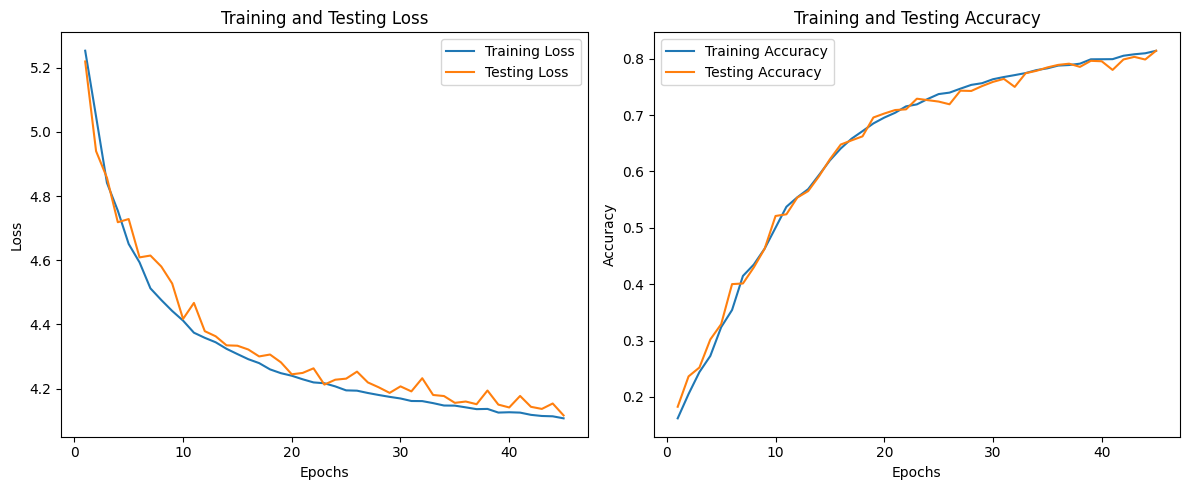

In [ ]:
import matplotlib.pyplot as plt
# Number of epochs (assuming length of lists is the number of epochs)
epochs = range(1, len(train_loss_list) + 1)

# Plot for Loss
plt.figure(figsize=(12, 5))

# First subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, test_loss_list, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs, test_accuracy_list, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
max(test_accuracy_list)

0.8143028846153846

In [ ]:
test_accuracy_list

[0.18249198717948717,
 0.23637820512820512,
 0.25220352564102566,
 0.30188301282051283,
 0.3291266025641026,
 0.40014022435897434,
 0.40124198717948717,
 0.42978766025641024,
 0.46304086538461536,
 0.5210336538461539,
 0.5240384615384616,
 0.5536858974358975,
 0.5652043269230769,
 0.5915464743589743,
 0.6216947115384616,
 0.6478365384615384,
 0.6552483974358975,
 0.6623597756410257,
 0.6958133012820513,
 0.7028245192307693,
 0.7090344551282052,
 0.7102363782051282,
 0.7291666666666666,
 0.7265625,
 0.7240584935897436,
 0.7192508012820513,
 0.7433894230769231,
 0.7428886217948718,
 0.7516025641025641,
 0.7590144230769231,
 0.7643229166666666,
 0.7501001602564102,
 0.7743389423076923,
 0.7786458333333334,
 0.7846554487179487,
 0.7891626602564102,
 0.7912660256410257,
 0.7856570512820513,
 0.7963741987179487,
 0.7955729166666666,
 0.7802483974358975,
 0.7987780448717948,
 0.8033854166666666,
 0.7986778846153846,
 0.8143028846153846]

In [ ]:
class Simclr_linear_eval(nn.Module):
    def __init__(self, encoder):
        super(Simclr_linear_eval, self).__init__()
        self.encoder = encoder
        self.encoder.resnet50.fc = nn.Linear(2048, 10)

    def forward(self, x):
        out = self.encoder(x)
        return out

In [ ]:
BATCH_SIZE = 128
EPOCHS = 30
DECAY = 5e-4
MOMENTUM = 0.9
LR = 1e-2
label_percentage = 0.01
pretrained_path = "rotnet_base_100_128_0.005.pth"

In [ ]:
BATCH_SIZE = 128
EPOCHS = 30
DECAY = 5e-4
MOMENTUM = 0.9
LR = 1e-2
label_percentage = 0.1

In [ ]:
train_transform = transforms.Compose(
    [transforms.Resize(size=(32, 32)),
    transforms.ToTensor()]
)
test_transform = transforms.Compose(
    [transforms.Resize(size=(32, 32)),
    transforms.ToTensor()]
)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainset, _ = torch.utils.data.random_split(trainset, [int(len(trainset)*label_percentage), int(len(trainset)*(1-label_percentage))])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet50()
rot_model.load_state_dict(torch.load("simclr_resnet50_128_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-267fd4941a39>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, data in enumerate(tqdm(trainloader)):


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-15-267fd4941a39>:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, data in enumerate(tqdm(testloader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0 Train Loss 103.91177368164062 Acc 0.252 ; Val Loss 86.76997375488281 Acc 0.4933


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Train Loss 58.793235778808594 Acc 0.61 ; Val Loss 42.35213088989258 Acc 0.6951


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Train Loss 35.908050537109375 Acc 0.732 ; Val Loss 55.63976287841797 Acc 0.678


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Train Loss 32.69300842285156 Acc 0.748 ; Val Loss 45.68787384033203 Acc 0.6915


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Train Loss 21.672565460205078 Acc 0.808 ; Val Loss 39.47969436645508 Acc 0.7249


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Train Loss 17.25519561767578 Acc 0.842 ; Val Loss 38.64808654785156 Acc 0.7414


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Train Loss 14.523601531982422 Acc 0.852 ; Val Loss 37.67876434326172 Acc 0.7491


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Train Loss 8.27138900756836 Acc 0.87 ; Val Loss 37.96735763549805 Acc 0.7388


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Train Loss 6.1790690422058105 Acc 0.89 ; Val Loss 37.751407623291016 Acc 0.7328


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Train Loss 3.4974279403686523 Acc 0.93 ; Val Loss 36.12666702270508 Acc 0.739


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Train Loss 2.506866455078125 Acc 0.934 ; Val Loss 35.9721794128418 Acc 0.7405


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 Train Loss 2.386091947555542 Acc 0.948 ; Val Loss 35.42128372192383 Acc 0.7435


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 Train Loss 1.7613284587860107 Acc 0.964 ; Val Loss 35.0558967590332 Acc 0.7431


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 Train Loss 1.537020206451416 Acc 0.968 ; Val Loss 34.803382873535156 Acc 0.7443


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 Train Loss 1.3486764430999756 Acc 0.962 ; Val Loss 34.586570739746094 Acc 0.7463


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 Train Loss 0.9991263151168823 Acc 0.962 ; Val Loss 34.347774505615234 Acc 0.746


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 Train Loss 1.1234389543533325 Acc 0.968 ; Val Loss 34.3131217956543 Acc 0.7463


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 Train Loss 1.4003275632858276 Acc 0.964 ; Val Loss 34.326820373535156 Acc 0.7461


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 Train Loss 1.4558440446853638 Acc 0.966 ; Val Loss 34.29635238647461 Acc 0.7451


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 Train Loss 0.7860932350158691 Acc 0.968 ; Val Loss 34.2465934753418 Acc 0.7445


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 Train Loss 0.747089147567749 Acc 0.974 ; Val Loss 34.156768798828125 Acc 0.7443


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 Train Loss 0.9456523060798645 Acc 0.98 ; Val Loss 34.21372604370117 Acc 0.7443


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 Train Loss 1.057822585105896 Acc 0.962 ; Val Loss 34.225704193115234 Acc 0.7443


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 Train Loss 0.605164647102356 Acc 0.972 ; Val Loss 34.24903869628906 Acc 0.7443


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 Train Loss 0.4633665084838867 Acc 0.99 ; Val Loss 34.260826110839844 Acc 0.7439


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 Train Loss 0.8886350393295288 Acc 0.968 ; Val Loss 34.22168731689453 Acc 0.7445


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 Train Loss 0.6954518556594849 Acc 0.974 ; Val Loss 34.19809341430664 Acc 0.7448


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 Train Loss 0.525290310382843 Acc 0.972 ; Val Loss 34.12312316894531 Acc 0.7453


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 Train Loss 0.6752873063087463 Acc 0.97 ; Val Loss 34.152984619140625 Acc 0.7452


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 Train Loss 0.5633127093315125 Acc 0.976 ; Val Loss 34.17380905151367 Acc 0.7449


In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet50()
rot_model.load_state_dict(torch.load("simclr_resnet50_128_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15, 20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet50()
rot_model.load_state_dict(torch.load("simclr_resnet50_256_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-6-bf6e53458673>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, data in enumerate(tqdm(trainloader)):


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-6-bf6e53458673>:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, data in enumerate(tqdm(testloader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0 Train Loss 57.505470275878906 Acc 0.234 ; Val Loss 26.677982330322266 Acc 0.6076


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Train Loss 28.278879165649414 Acc 0.64 ; Val Loss 25.666522979736328 Acc 0.6852


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Train Loss 15.903932571411133 Acc 0.768 ; Val Loss 24.253652572631836 Acc 0.7353


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Train Loss 13.222192764282227 Acc 0.816 ; Val Loss 24.288822174072266 Acc 0.7489


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Train Loss 9.741127967834473 Acc 0.852 ; Val Loss 21.087465286254883 Acc 0.756


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Train Loss 6.021941184997559 Acc 0.88 ; Val Loss 21.974212646484375 Acc 0.7495


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Train Loss 2.901350498199463 Acc 0.928 ; Val Loss 22.49196434020996 Acc 0.7494


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Train Loss 2.25014591217041 Acc 0.934 ; Val Loss 21.980304718017578 Acc 0.7486


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Train Loss 1.49086332321167 Acc 0.956 ; Val Loss 21.782846450805664 Acc 0.7493


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Train Loss 0.7469556927680969 Acc 0.968 ; Val Loss 21.948429107666016 Acc 0.7428


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Train Loss 0.41590118408203125 Acc 0.978 ; Val Loss 21.861034393310547 Acc 0.7431


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 Train Loss 0.25968775153160095 Acc 0.98 ; Val Loss 21.7409725189209 Acc 0.743


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 Train Loss 0.509365439414978 Acc 0.976 ; Val Loss 21.646272659301758 Acc 0.7444


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 Train Loss 0.1730153113603592 Acc 0.984 ; Val Loss 21.567134857177734 Acc 0.7456


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 Train Loss 0.3708915710449219 Acc 0.98 ; Val Loss 21.535430908203125 Acc 0.7459


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 Train Loss 0.15014995634555817 Acc 0.986 ; Val Loss 21.49225616455078 Acc 0.7475


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 Train Loss 0.19156211614608765 Acc 0.986 ; Val Loss 21.446456909179688 Acc 0.7474


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 Train Loss 0.24836109578609467 Acc 0.986 ; Val Loss 21.373924255371094 Acc 0.7485


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 Train Loss 0.131851464509964 Acc 0.992 ; Val Loss 21.40809440612793 Acc 0.7499


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 Train Loss 0.015267008915543556 Acc 0.996 ; Val Loss 21.392852783203125 Acc 0.75


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 Train Loss 0.14654040336608887 Acc 0.994 ; Val Loss 21.40914535522461 Acc 0.7492


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 Train Loss 0.4052014946937561 Acc 0.974 ; Val Loss 21.405424118041992 Acc 0.7496


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 Train Loss 0.15000277757644653 Acc 0.988 ; Val Loss 21.3891544342041 Acc 0.7496


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 Train Loss 0.04413712024688721 Acc 0.988 ; Val Loss 21.355289459228516 Acc 0.7495


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 Train Loss 0.01774880848824978 Acc 0.998 ; Val Loss 21.32211685180664 Acc 0.7496


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 Train Loss 0.2387072592973709 Acc 0.994 ; Val Loss 21.340038299560547 Acc 0.7496


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 Train Loss 0.1792607456445694 Acc 0.986 ; Val Loss 21.39036750793457 Acc 0.7492


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 Train Loss 0.07991145551204681 Acc 0.988 ; Val Loss 21.348031997680664 Acc 0.7496


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 Train Loss 0.12089891731739044 Acc 0.992 ; Val Loss 21.287588119506836 Acc 0.75


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 Train Loss 0.03407496586441994 Acc 0.996 ; Val Loss 21.28577423095703 Acc 0.7503


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet50()
rot_model.load_state_dict(torch.load("simclr_resnet50_256_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15, 20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0 Train Loss 23.112964630126953 Acc 0.6794 ; Val Loss 14.736516952514648 Acc 0.7742


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Train Loss 11.92049789428711 Acc 0.7868 ; Val Loss 11.408390998840332 Acc 0.7877


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Train Loss 7.932651519775391 Acc 0.816 ; Val Loss 11.442935943603516 Acc 0.7783


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Train Loss 8.12851619720459 Acc 0.8256 ; Val Loss 16.085927963256836 Acc 0.7491


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Train Loss 7.2412261962890625 Acc 0.8356 ; Val Loss 13.76117992401123 Acc 0.7554


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Train Loss 3.6998062133789062 Acc 0.8904 ; Val Loss 10.347578048706055 Acc 0.8055


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Train Loss 2.3851447105407715 Acc 0.915 ; Val Loss 9.758782386779785 Acc 0.8049


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Train Loss 1.9938935041427612 Acc 0.9198 ; Val Loss 9.657604217529297 Acc 0.8044


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Train Loss 1.5417836904525757 Acc 0.9186 ; Val Loss 9.699860572814941 Acc 0.8059


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Train Loss 1.6819900274276733 Acc 0.9292 ; Val Loss 9.468097686767578 Acc 0.802


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Train Loss 1.4027466773986816 Acc 0.9344 ; Val Loss 9.173487663269043 Acc 0.8007


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 Train Loss 1.4170719385147095 Acc 0.9422 ; Val Loss 9.16147518157959 Acc 0.8011


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 Train Loss 1.1873408555984497 Acc 0.9404 ; Val Loss 8.787469863891602 Acc 0.8036


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 Train Loss 1.2046928405761719 Acc 0.9362 ; Val Loss 9.111831665039062 Acc 0.8047


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 Train Loss 1.1218181848526 Acc 0.9422 ; Val Loss 9.006633758544922 Acc 0.8016


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 Train Loss 1.0537681579589844 Acc 0.9408 ; Val Loss 8.858013153076172 Acc 0.8043


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 Train Loss 1.2208302021026611 Acc 0.9434 ; Val Loss 9.044058799743652 Acc 0.8047


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 Train Loss 0.9877791404724121 Acc 0.9444 ; Val Loss 9.03193473815918 Acc 0.804


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 Train Loss 0.8925263285636902 Acc 0.9434 ; Val Loss 9.120545387268066 Acc 0.8029


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 Train Loss 1.0770374536514282 Acc 0.9418 ; Val Loss 9.00730037689209 Acc 0.8047


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 Train Loss 1.047378420829773 Acc 0.9436 ; Val Loss 8.853391647338867 Acc 0.8047


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 Train Loss 0.9331279993057251 Acc 0.941 ; Val Loss 9.300379753112793 Acc 0.8028


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 Train Loss 1.076626181602478 Acc 0.9406 ; Val Loss 9.121988296508789 Acc 0.8055


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 Train Loss 0.8938124775886536 Acc 0.945 ; Val Loss 9.071807861328125 Acc 0.804


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 Train Loss 0.9927700161933899 Acc 0.9384 ; Val Loss 9.02763843536377 Acc 0.8041


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 Train Loss 0.9641610980033875 Acc 0.9386 ; Val Loss 9.069982528686523 Acc 0.8032


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 Train Loss 0.9008654952049255 Acc 0.94 ; Val Loss 9.011258125305176 Acc 0.8046


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 Train Loss 1.3601852655410767 Acc 0.937 ; Val Loss 9.035283088684082 Acc 0.8037


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 Train Loss 1.5220187902450562 Acc 0.9432 ; Val Loss 9.061882972717285 Acc 0.8045


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 Train Loss 1.0390609502792358 Acc 0.9432 ; Val Loss 9.056882858276367 Acc 0.8044


In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet50()
rot_model.load_state_dict(torch.load("simclr_resnet50_64_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

<ipython-input-9-269cfda05b87>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, data in enumerate(tqdm(trainloader)):


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-9-269cfda05b87>:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, data in enumerate(tqdm(testloader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0 Train Loss 139.39016723632812 Acc 0.272 ; Val Loss 87.10025787353516 Acc 0.576


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Train Loss 79.31832122802734 Acc 0.63 ; Val Loss 91.21843719482422 Acc 0.6392


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Train Loss 70.01353454589844 Acc 0.724 ; Val Loss 91.14013671875 Acc 0.6909


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Train Loss 51.05779266357422 Acc 0.758 ; Val Loss 78.09700012207031 Acc 0.7103


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Train Loss 42.09943389892578 Acc 0.802 ; Val Loss 74.79658508300781 Acc 0.7068


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Train Loss 30.552364349365234 Acc 0.816 ; Val Loss 69.40796661376953 Acc 0.7068


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Train Loss 16.919795989990234 Acc 0.844 ; Val Loss 72.40855407714844 Acc 0.7014


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Train Loss 12.961854934692383 Acc 0.878 ; Val Loss 71.68353271484375 Acc 0.6939


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Train Loss 8.722541809082031 Acc 0.906 ; Val Loss 63.30342102050781 Acc 0.7098


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Train Loss 6.189207077026367 Acc 0.932 ; Val Loss 67.39521026611328 Acc 0.7075


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Train Loss 6.689182758331299 Acc 0.918 ; Val Loss 66.39210510253906 Acc 0.7085


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 Train Loss 5.536147594451904 Acc 0.928 ; Val Loss 64.16016387939453 Acc 0.7134


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 Train Loss 3.704035520553589 Acc 0.942 ; Val Loss 62.60335159301758 Acc 0.7125


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 Train Loss 2.3773257732391357 Acc 0.956 ; Val Loss 62.01354217529297 Acc 0.7106


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 Train Loss 2.7228550910949707 Acc 0.956 ; Val Loss 62.378334045410156 Acc 0.7088


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 Train Loss 1.4844679832458496 Acc 0.96 ; Val Loss 62.430763244628906 Acc 0.7083


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 Train Loss 1.0306622982025146 Acc 0.978 ; Val Loss 62.49882888793945 Acc 0.7079


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 Train Loss 1.3419334888458252 Acc 0.968 ; Val Loss 62.3450813293457 Acc 0.7091


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 Train Loss 1.1909099817276 Acc 0.974 ; Val Loss 62.068416595458984 Acc 0.7106


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 Train Loss 1.395404577255249 Acc 0.968 ; Val Loss 61.74178695678711 Acc 0.7128


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 Train Loss 0.8816982507705688 Acc 0.972 ; Val Loss 61.69186019897461 Acc 0.7127


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 Train Loss 0.9507824778556824 Acc 0.982 ; Val Loss 61.59764099121094 Acc 0.7128


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 Train Loss 0.899616003036499 Acc 0.978 ; Val Loss 61.544742584228516 Acc 0.7132


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 Train Loss 0.5900229215621948 Acc 0.982 ; Val Loss 61.46198272705078 Acc 0.7137


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 Train Loss 0.36304500699043274 Acc 0.986 ; Val Loss 61.363609313964844 Acc 0.7134


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 Train Loss 0.973588228225708 Acc 0.98 ; Val Loss 61.34992599487305 Acc 0.7137


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 Train Loss 0.770028829574585 Acc 0.988 ; Val Loss 61.385677337646484 Acc 0.7134


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 Train Loss 0.7366594076156616 Acc 0.988 ; Val Loss 61.21772003173828 Acc 0.7137


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 Train Loss 1.085235357284546 Acc 0.978 ; Val Loss 61.222801208496094 Acc 0.7134


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 Train Loss 0.5567044019699097 Acc 0.978 ; Val Loss 61.233985900878906 Acc 0.7136


In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet50()
rot_model.load_state_dict(torch.load("simclr_resnet50_64_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15, 20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0 Train Loss 79.12505340576172 Acc 0.6404 ; Val Loss 59.18304443359375 Acc 0.7219


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Train Loss 41.51863479614258 Acc 0.7442 ; Val Loss 40.96501922607422 Acc 0.743


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Train Loss 24.641950607299805 Acc 0.7788 ; Val Loss 46.24070358276367 Acc 0.6829


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Train Loss 26.85053062438965 Acc 0.7742 ; Val Loss 35.30132293701172 Acc 0.7388


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Train Loss 31.410551071166992 Acc 0.7716 ; Val Loss 45.71604919433594 Acc 0.7261


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Train Loss 16.5456600189209 Acc 0.8372 ; Val Loss 30.848894119262695 Acc 0.7765


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Train Loss 10.562166213989258 Acc 0.8674 ; Val Loss 27.81722640991211 Acc 0.7751


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Train Loss 8.365336418151855 Acc 0.8774 ; Val Loss 26.476581573486328 Acc 0.774


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Train Loss 7.161383152008057 Acc 0.8822 ; Val Loss 24.550064086914062 Acc 0.7783


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Train Loss 6.604790687561035 Acc 0.8916 ; Val Loss 24.221763610839844 Acc 0.7734


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Train Loss 4.739396095275879 Acc 0.901 ; Val Loss 23.793283462524414 Acc 0.7733


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 Train Loss 5.008781433105469 Acc 0.9066 ; Val Loss 23.26286506652832 Acc 0.7723


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 Train Loss 4.735286235809326 Acc 0.9006 ; Val Loss 23.48508644104004 Acc 0.7736


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 Train Loss 5.412415981292725 Acc 0.8996 ; Val Loss 23.53416633605957 Acc 0.7717


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 Train Loss 4.884703159332275 Acc 0.9046 ; Val Loss 22.979774475097656 Acc 0.7749


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 Train Loss 4.330115795135498 Acc 0.9084 ; Val Loss 23.06996726989746 Acc 0.773


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 Train Loss 5.948216438293457 Acc 0.906 ; Val Loss 23.1517276763916 Acc 0.773


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 Train Loss 5.2189812660217285 Acc 0.9024 ; Val Loss 23.12639808654785 Acc 0.7752


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 Train Loss 4.516462326049805 Acc 0.8996 ; Val Loss 23.381507873535156 Acc 0.7736


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 Train Loss 3.8068299293518066 Acc 0.9108 ; Val Loss 23.497425079345703 Acc 0.7721


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 Train Loss 4.084366798400879 Acc 0.904 ; Val Loss 23.299972534179688 Acc 0.7742


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 Train Loss 4.051328659057617 Acc 0.9088 ; Val Loss 23.320520401000977 Acc 0.7718


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 Train Loss 5.11102294921875 Acc 0.9028 ; Val Loss 23.059240341186523 Acc 0.7726


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 Train Loss 4.921570777893066 Acc 0.9068 ; Val Loss 23.412275314331055 Acc 0.7737


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 Train Loss 4.544577121734619 Acc 0.9102 ; Val Loss 23.258344650268555 Acc 0.7735


  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ResNet20(nn.Module):
    def __init__(self, projection_dim=128):
        super(ResNet20, self).__init__()
        # Initialize ResNet20
        self.resnet20 = models.resnet18(pretrained=False)  # ResNet18 is the closest standard model to ResNet20
        # Adjust the first convolution layer
        self.resnet20.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet20.maxpool = nn.Identity()
        # Adjust the fully connected layer
        feature_dim = self.resnet20.fc.in_features
        self.resnet20.fc = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        projection = self.resnet20(x)
        return projection

In [ ]:
class Simclr_linear_eval(nn.Module):
    def __init__(self, encoder):
        super(Simclr_linear_eval, self).__init__()
        self.encoder = encoder
        self.encoder.resnet20.fc = nn.Linear(512, 10)

    def forward(self, x):
        out = self.encoder(x)
        return out

In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet20()
rot_model.load_state_dict(torch.load("simclr_resnet20_128_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0 Train Loss 13.293571472167969 Acc 0.6422 ; Val Loss 7.800197124481201 Acc 0.722


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Train Loss 6.709327220916748 Acc 0.7124 ; Val Loss 7.731207370758057 Acc 0.696


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Train Loss 5.552537441253662 Acc 0.7304 ; Val Loss 7.023099899291992 Acc 0.6944


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Train Loss 7.0032196044921875 Acc 0.7228 ; Val Loss 8.581619262695312 Acc 0.7011


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Train Loss 6.794598579406738 Acc 0.7394 ; Val Loss 9.303403854370117 Acc 0.6909


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Train Loss 6.821326732635498 Acc 0.7406 ; Val Loss 8.53551959991455 Acc 0.723


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Train Loss 6.2293620109558105 Acc 0.754 ; Val Loss 8.930276870727539 Acc 0.7072


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Train Loss 5.512405872344971 Acc 0.7678 ; Val Loss 11.413958549499512 Acc 0.6871


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Train Loss 6.367772579193115 Acc 0.7628 ; Val Loss 8.874664306640625 Acc 0.7184


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Train Loss 5.879536151885986 Acc 0.7666 ; Val Loss 9.771660804748535 Acc 0.7258


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Train Loss 3.695862293243408 Acc 0.8216 ; Val Loss 7.47614860534668 Acc 0.7528


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 Train Loss 2.5534465312957764 Acc 0.8436 ; Val Loss 7.007720947265625 Acc 0.7491


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 Train Loss 2.3508801460266113 Acc 0.852 ; Val Loss 6.670097351074219 Acc 0.7444


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 Train Loss 2.2348575592041016 Acc 0.8488 ; Val Loss 6.56178092956543 Acc 0.7413


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 Train Loss 2.0089714527130127 Acc 0.8532 ; Val Loss 6.3036675453186035 Acc 0.7465


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 Train Loss 1.7173223495483398 Acc 0.8596 ; Val Loss 6.232571125030518 Acc 0.7419


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 Train Loss 1.7588837146759033 Acc 0.854 ; Val Loss 6.143100261688232 Acc 0.7424


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 Train Loss 2.090106964111328 Acc 0.8552 ; Val Loss 6.402632236480713 Acc 0.7397


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 Train Loss 1.6866486072540283 Acc 0.8528 ; Val Loss 5.9112629890441895 Acc 0.7381


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 Train Loss 1.5990132093429565 Acc 0.8538 ; Val Loss 6.019999980926514 Acc 0.7331


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 Train Loss 1.8953603506088257 Acc 0.8562 ; Val Loss 5.887491226196289 Acc 0.7402


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 Train Loss 1.3444708585739136 Acc 0.8644 ; Val Loss 5.703647136688232 Acc 0.7378


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 Train Loss 1.5123791694641113 Acc 0.862 ; Val Loss 5.855099201202393 Acc 0.737


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 Train Loss 1.3262863159179688 Acc 0.8632 ; Val Loss 5.757904052734375 Acc 0.7422


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 Train Loss 1.2401466369628906 Acc 0.866 ; Val Loss 5.742803573608398 Acc 0.7414


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 Train Loss 1.329116702079773 Acc 0.8734 ; Val Loss 5.839723110198975 Acc 0.7395


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 Train Loss 1.3382635116577148 Acc 0.8674 ; Val Loss 5.801202297210693 Acc 0.7385


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 Train Loss 1.431536078453064 Acc 0.8652 ; Val Loss 5.813933849334717 Acc 0.7388


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 Train Loss 1.6108921766281128 Acc 0.8706 ; Val Loss 5.654511451721191 Acc 0.7394


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 Train Loss 1.291312575340271 Acc 0.8762 ; Val Loss 5.649594783782959 Acc 0.7449


In [ ]:
criterion = nn.CrossEntropyLoss()
from torch.optim import optimizer
from tqdm import tqdm_notebook as tqdm
rot_model = ResNet20()
rot_model.load_state_dict(torch.load("simclr_resnet20_128_200ep.pt"))
rot_model.cuda()

rot_linear_eval_model = Simclr_linear_eval(rot_model)
rot_linear_eval_model.cuda()

#optimizer = torch.optim.SGD(rot_linear_eval_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=DECAY)
optimizer = torch.optim.Adam(rot_linear_eval_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
best_loss = 9999999

DECAY_EPOCHS = 10
for epoch_idx in range(EPOCHS):
    epoch_losses = 0
    epoch_corrects = 0
    rot_linear_eval_model.train()
    for batch_idx, data in enumerate(tqdm(trainloader)):
        image, label = data
        image = image.cuda()
        label = label.cuda()

        rot_linear_eval_model.zero_grad()
        out = rot_linear_eval_model(image)

        loss = criterion(out, label)
        loss.backward()
        optimizer.step()

        epoch_losses += loss

        pred = torch.argmax(out, dim=1)
        epoch_corrects += torch.sum(pred == label).item()

    epoch_losses /= len(trainloader)
    epoch_corrects /= len(trainset)


    with torch.no_grad():
        rot_linear_eval_model.eval()

        test_epoch_losses = 0
        test_epoch_corrects = 0

        for batch_idx, data in enumerate(tqdm(testloader)):
            image, label = data
            image = image.cuda()
            label = label.cuda()

            out = rot_linear_eval_model(image)

            loss = criterion(out, label)

            test_epoch_losses += loss

            pred = torch.argmax(out, dim=1)
            test_epoch_corrects += torch.sum(pred == label).item()

        test_epoch_losses /= len(testloader)
        test_epoch_corrects /= len(testset)

        if test_epoch_losses < best_loss:
            best_loss = test_epoch_losses
            torch.save(rot_linear_eval_model.state_dict(), f'simclr_model_semi_sup_{EPOCHS}_{BATCH_SIZE}_{LR}_{label_percentage}.pth')

    scheduler.step()
    print(f'Epoch {epoch_idx} Train Loss {epoch_losses} Acc {epoch_corrects} ; Val Loss {test_epoch_losses} Acc {test_epoch_corrects}')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0 Train Loss 24.543535232543945 Acc 0.302 ; Val Loss 21.589248657226562 Acc 0.4915


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Train Loss 12.454488754272461 Acc 0.648 ; Val Loss 12.656875610351562 Acc 0.6552


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Train Loss 9.10329532623291 Acc 0.694 ; Val Loss 14.296109199523926 Acc 0.6605


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Train Loss 6.668707370758057 Acc 0.766 ; Val Loss 11.618597984313965 Acc 0.7051


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Train Loss 5.07692813873291 Acc 0.812 ; Val Loss 11.636958122253418 Acc 0.6994


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Train Loss 4.180066108703613 Acc 0.8 ; Val Loss 12.056404113769531 Acc 0.6965


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Train Loss 2.943782329559326 Acc 0.832 ; Val Loss 11.569421768188477 Acc 0.7006


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Train Loss 1.9555456638336182 Acc 0.866 ; Val Loss 11.628525733947754 Acc 0.6898


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Train Loss 1.3806266784667969 Acc 0.896 ; Val Loss 11.006062507629395 Acc 0.6911


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Train Loss 1.1684640645980835 Acc 0.908 ; Val Loss 10.67838191986084 Acc 0.6855


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Train Loss 0.5141860246658325 Acc 0.938 ; Val Loss 10.696194648742676 Acc 0.6857


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 Train Loss 0.5053448677062988 Acc 0.934 ; Val Loss 10.644325256347656 Acc 0.6854


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 Train Loss 0.5863988399505615 Acc 0.928 ; Val Loss 10.679884910583496 Acc 0.686


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 Train Loss 0.4113406538963318 Acc 0.956 ; Val Loss 10.741825103759766 Acc 0.6828


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 Train Loss 0.4544687569141388 Acc 0.93 ; Val Loss 10.762107849121094 Acc 0.6834


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 Train Loss 0.3268316388130188 Acc 0.948 ; Val Loss 10.726730346679688 Acc 0.6844


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 Train Loss 0.27491992712020874 Acc 0.95 ; Val Loss 10.667454719543457 Acc 0.6853


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 Train Loss 0.18896815180778503 Acc 0.964 ; Val Loss 10.623565673828125 Acc 0.6867


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 Train Loss 0.32313457131385803 Acc 0.946 ; Val Loss 10.513891220092773 Acc 0.6873


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 Train Loss 0.22042347490787506 Acc 0.956 ; Val Loss 10.500017166137695 Acc 0.6881


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 Train Loss 0.4484937787055969 Acc 0.954 ; Val Loss 10.506672859191895 Acc 0.6883


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 Train Loss 0.26647675037384033 Acc 0.95 ; Val Loss 10.485833168029785 Acc 0.6879


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 Train Loss 0.22943884134292603 Acc 0.96 ; Val Loss 10.469861030578613 Acc 0.6884


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 Train Loss 0.28254157304763794 Acc 0.964 ; Val Loss 10.46776294708252 Acc 0.6879


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 Train Loss 0.06909339129924774 Acc 0.98 ; Val Loss 10.452187538146973 Acc 0.6873


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 Train Loss 0.27525365352630615 Acc 0.964 ; Val Loss 10.466897010803223 Acc 0.6868


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 Train Loss 0.15457582473754883 Acc 0.968 ; Val Loss 10.474517822265625 Acc 0.6868


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 Train Loss 0.09468305855989456 Acc 0.974 ; Val Loss 10.46064281463623 Acc 0.6869


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 Train Loss 0.16984716057777405 Acc 0.964 ; Val Loss 10.477206230163574 Acc 0.6877


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 Train Loss 0.20119519531726837 Acc 0.964 ; Val Loss 10.475857734680176 Acc 0.6876
